In [2]:
import shapely.wkt as sw
import numpy as np

import os.path
from tensorflow.keras.utils import to_categorical
import copy
import time
from preproc import encode_point_set, transform_data, fix_single_class, stratify_nested
from util import test_dim, draw_hist, load_wkt, test_angle_edge_consist

In [ ]:
geometry, labels = load_wkt('../data/shape_set.tsv')

In [ ]:
geometry_positive, labels_positive = load_wkt('../data/good_big.tsv')
geometry += geometry_positive
labels += labels_positive

In [10]:
# making numpy feature and label array
polygons = transform_data(geometry)

In [9]:
test_angle_edge_consist(geometry, polygons)

In [ ]:
polygons = np.array(polygons)
lbl = np.array(labels)

In [12]:
# extracting angles and their min, max
angles = np.hstack(polygons[:,0])
min_angle = np.min(angles)
max_angle = np.max(angles)
print("Min angle: {} rad {} deg \n Max angle: {} rad {} deg".format(min_angle, min_angle*180/math.pi, max_angle, max_angle*180/math.pi))

Min angle: 0.0 rad 0.0 deg 
 Max angle: 6.2822123274050625 rad 359.94425236536824 deg


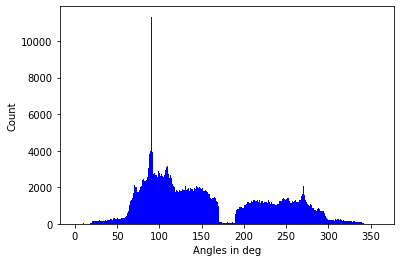

In [13]:
# angle distribution histogram
draw_hist(angles*180/math.pi,360,'blue','Angles in deg','Count')

In [15]:
# add number of edges column
n_edge = np.array([len(p) for p in polygons[:,0]])
n_edge = n_edge.reshape((n_edge.shape[0],1))
polygons = np.hstack((polygons,n_edge))

(24000, 1)


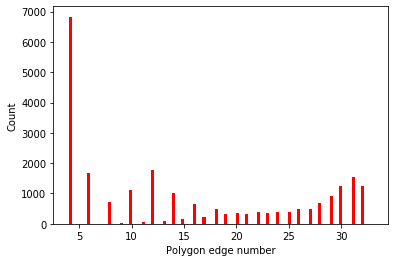

In [16]:
# histogram of number of edges
strat_edgeno = polygons[:,2].copy()
strat_edgeno = strat_edgeno.reshape(-1, 1)
print(strat_edgeno.shape)
draw_hist(strat_edgeno,num_bins=100,color='red',xlabel='Polygon edge number',ylabel='Count')

14000
10000


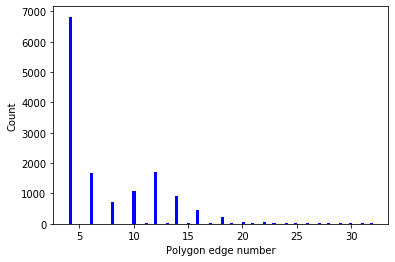

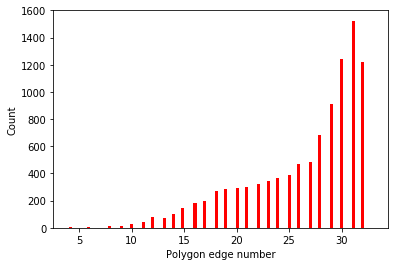

In [17]:
# --------------> NEW pos and neg
p = strat_edgeno[lbl==1]
print(len(p))
draw_hist(p,num_bins=100,color='blue',xlabel='Polygon edge number',ylabel='Count')
n = strat_edgeno[lbl==0]
print(len(n))
draw_hist(n,num_bins=100,color='red',xlabel='Polygon edge number',ylabel='Count')

In [19]:
polygons = fix_single_class(polygons, strat_edgeno)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = stratify_nested(polygons, lbl)

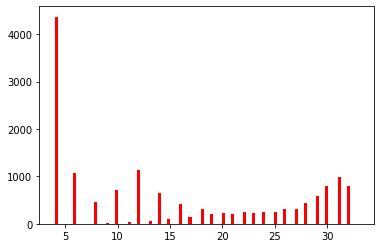

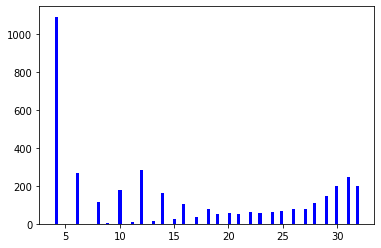

TRAIN:15360
1: 8960
0: 6400
R: 0.5833333333333334

VAL:3840
1: 2240
0: 1600
R: 0.5833333333333334

TEST:4800
1: 2800
0: 2000
R: 0.5833333333333334



In [25]:
draw_hist(X_train[:,2].reshape(-1,1),100)
draw_hist(X_val[:,2].reshape(-1,1),100,color='blue')

print(f"TRAIN:{y_train.size}\n1: {y_train[y_train==1].size}\n0: {y_train[y_train==0].size}\nR: {y_train[y_train==1].size/y_train.size}\n")
print(f"VAL:{y_val.size}\n1: {y_val[y_val==1].size}\n0: {y_val[y_val==0].size}\nR: {y_val[y_val==1].size/y_val.size}\n")
print(f"TEST:{y_test.size}\n1: {y_test[y_test==1].size}\n0: {y_test[y_test==0].size}\nR: {y_test[y_test==1].size/y_test.size}\n")

(8960, 1)
6400
----------------------------------------------------------------
(2800, 1)
2000


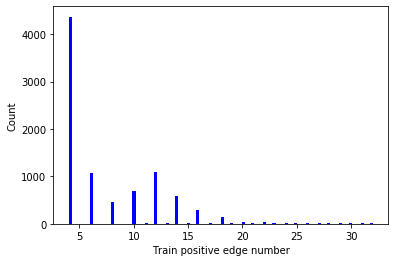

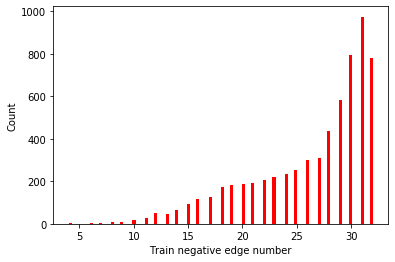

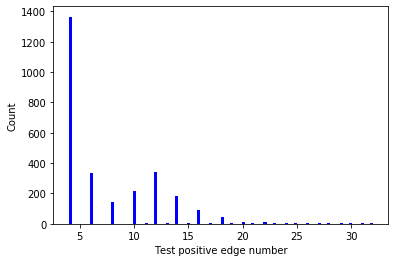

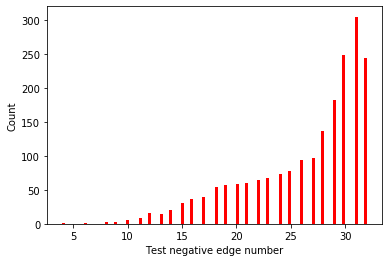

In [35]:
ptrain = X_train[y_train==1]
ptrain = ptrain[:,2].reshape(-1,1)
print(ptrain.shape)
draw_hist(ptrain,num_bins=100,color='blue',xlabel='Train positive edge number',ylabel='Count')
ntrain = X_train[y_train==0]
ntrain = ntrain[:,2].reshape(-1,1)
print(len(ntrain))
draw_hist(ntrain,num_bins=100,color='red',xlabel='Train negative edge number',ylabel='Count')
print('----------------------------------------------------------------')
ptest = X_test[y_test==1]
ptest = ptest[:,2].reshape(-1,1)
print(ptest.shape)
draw_hist(ptest,num_bins=100,color='blue',xlabel='Test positive edge number',ylabel='Count')
ntest = X_test[y_test==0]
ntest = ntest[:,2].reshape(-1,1)
print(len(ntest))
draw_hist(ntest,num_bins=100,color='red',xlabel='Test negative edge number',ylabel='Count')


In [26]:
# remove number of edges col
X_train = np.delete(X_train, 3, 1)
X_val = np.delete(X_val, 3, 1)
X_test = np.delete(X_test, 3, 1)

In [27]:
# Sort descending by number of angles - prep for batch padding
# Not necessary since masking is used
argsorted = X_train[:,2].argsort()[::-1]
X_train_sorted = X_train[argsorted]
Y_train_sorted = Y_train[argsorted]

In [28]:
# deload memory
del polygons
del strat_edgeno
del labels
del lbl
del X_train
del y_train
del Y_train

In [30]:
X_train_list = copy.deepcopy(X_train_sorted[:,:2].tolist())
X_val_list = copy.deepcopy(X_val[:,:2].tolist())
X_test_list = copy.deepcopy(X_test[:,:2].tolist())

Y_train_list = copy.deepcopy(Y_train_sorted.tolist())
Y_val_list = copy.deepcopy(Y_val.tolist())
Y_test_list = copy.deepcopy(Y_test.tolist())

In [31]:
#reshape list from (n_samples,channels,features) to (n_samples,features,channels)
for i in range(len(X_train_list)):
    X_train_list[i] = np.array(X_train_list[i]).T.tolist()
for i in range(len(X_val_list)):
    X_val_list[i] = np.array(X_val_list[i]).T.tolist()
for i in range(len(X_test_list)):
    X_test_list[i] = np.array(X_test_list[i]).T.tolist()

In [58]:
import datetime
import tensorflow as tf
from custom_tf import DataGenerator, PredictDataGenerator
from models import baselineNet, baselineMaskNet, maskConvNet, maskDenseNet, maskModelDenseReg
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.debugging import is_numeric_tensor
from tensorflow.keras.optimizers import Adam
from tensorflow.losses import sigmoid_cross_entropy

In [59]:
train_generator = DataGenerator(X_train_list,Y_train_list,batch_size=128,pc_first_kernel_size=3,mask_model=True)
#train_generator = DataGenerator(X_train_list,Y_train_list,batch_size=64,mask_model=True)
val_generator = DataGenerator(X_val_list, Y_val_list,batch_size=64,mask_model=True)
test_generator = DataGenerator(X_test_list,Y_test_list,batch_size=1,mask_model=True)
checkpoint = ModelCheckpoint(f'bestMaskDense{datetime.datetime.now()}.h5', verbose=0, save_best_only=True, save_weights_only=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [60]:
tf.keras.backend.clear_session()

In [42]:
model = baselineMaskNet()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          448       
_________________________________________________________________
my_global_average_pooling1d  (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
model.fit_generator(generator=train_generator,
                    epochs=200,
                    validation_data=val_generator,
                    use_multiprocessing=False,
                    workers=0)
end = time.time()
print(f'Elapsed: {(end-start)/60}m{(end-start)%60}s')

In [61]:
model2 = MaskDenseNet()
model2.summary()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         1792      
_________________________________________________________________
my_global_average_pooling1d  (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
__________

In [62]:
start = time.time()
hystory = model2.fit_generator(generator=train_generator,
                    epochs=600,
                    validation_data=val_generator,
                    verbose=2,
                    callbacks=[checkpoint, earlyStopping, reduce_lr]).history
end = time.time()
print(f'Elapsed: {(end-start)/60:.2f}m{(end-start)%60:.2f}s')

Epoch 1/600
60/60 [==============================] - 0s 6ms/step - loss: 0.6476 - acc: 0.5833
 - 2s - loss: 0.6947 - acc: 0.5288 - val_loss: 0.6476 - val_acc: 0.5833
Epoch 2/600
60/60 [==============================] - 0s 6ms/step - loss: 0.5068 - acc: 0.7521
 - 1s - loss: 0.5325 - acc: 0.7624 - val_loss: 0.5068 - val_acc: 0.7521
Epoch 3/600
60/60 [==============================] - 0s 5ms/step - loss: 0.1714 - acc: 0.9331
 - 1s - loss: 0.3060 - acc: 0.8686 - val_loss: 0.1714 - val_acc: 0.9331
Epoch 4/600
60/60 [==============================] - 0s 6ms/step - loss: 0.1174 - acc: 0.9672
 - 1s - loss: 0.2218 - acc: 0.9222 - val_loss: 0.1174 - val_acc: 0.9672
Epoch 5/600
60/60 [==============================] - 0s 5ms/step - loss: 0.1103 - acc: 0.9719
 - 1s - loss: 0.1358 - acc: 0.9562 - val_loss: 0.1103 - val_acc: 0.9719
Epoch 6/600
60/60 [==============================] - 0s 6ms/step - loss: 0.1350 - acc: 0.9552
 - 1s - loss: 0.1227 - acc: 0.9608 - val_loss: 0.1350 - val_acc: 0.9552
Epoc

In [96]:
model2.evaluate_generator(test_generator)

[0.09868371135162937, 0.98041666]

In [36]:
model2.save_weights('FULLDATA_mask_dense_e600.h5')

In [7]:
import pickle

def predict_angle_edge_format(geometry):
    #polygons = []
    for i in range(len(geometry)):
        if i % 300000 == 0:
            print(f'angle-edge index: {i}')
        geometry[i] = encode_point_set(geometry[i])
        #del geometry[0]
    #return polygons

In [10]:
mod = MaskDenseNet()
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#mod.load_weights('../models/Fmask_dense_e600_test9804.h5')
mod.load_weights('FULLDATA_mask_dense_e600.h5')

In [8]:
geometry = []

with open('../data/canada_buildings.tsv', 'r') as f:
# with open('../data/negative.tsv', 'r') as f:
    # i = 0
    for line in f:
        # if i == 6000000:
        #     break
        pol, _ = line.rstrip().split('\t')
        # pol = line.rstrip()
        # if i >= 6000000:
        geometry.append(sw.loads(pol))
        #i+=1

print(f'Number of polygons {len(geometry)}')
#print(f'{i - len(geometry)}')

Number of polygons 12663475


In [17]:
# test angle_edge correctness
n_check = []
for i in range(len(geometry)):
    n_check.append(len(geometry[i].exterior.coords[:-1]))

In [9]:
# making numpy feature and label array
#polygons = predict_angle_edge_format(geometry)
#print(geometry)
#print(geometry[0])
#print('-------------------------')
predict_angle_edge_format(geometry)
#print(geometry[0])
print('------------------END')
#poly = np.array(polygons)

angle-edge index: 0
angle-edge index: 300000
angle-edge index: 600000
angle-edge index: 900000
angle-edge index: 1200000
angle-edge index: 1500000
angle-edge index: 1800000
angle-edge index: 2100000
angle-edge index: 2400000
angle-edge index: 2700000
angle-edge index: 3000000
angle-edge index: 3300000
angle-edge index: 3600000
angle-edge index: 3900000
angle-edge index: 4200000
angle-edge index: 4500000
angle-edge index: 4800000
angle-edge index: 5100000
angle-edge index: 5400000
angle-edge index: 5700000
angle-edge index: 6000000
angle-edge index: 6300000
angle-edge index: 6600000
angle-edge index: 6900000
angle-edge index: 7200000
angle-edge index: 7500000
angle-edge index: 7800000
angle-edge index: 8100000
angle-edge index: 8400000
angle-edge index: 8700000
angle-edge index: 9000000
angle-edge index: 9300000
angle-edge index: 9600000
angle-edge index: 9900000
angle-edge index: 10200000
angle-edge index: 10500000
angle-edge index: 10800000
angle-edge index: 11100000
angle-edge index:

In [10]:
for i in range(len(geometry)):
    geometry[i] = len(geometry[i][0])
print(len(geometry))

12663475


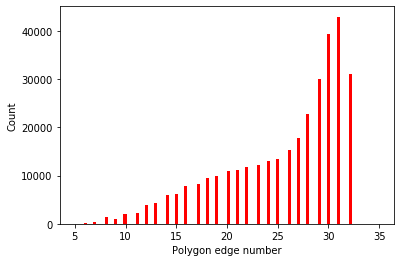

In [53]:
draw_hist(geometry,num_bins=100,color='red',xlabel='Polygon edge number',ylabel='Count')

In [15]:
with open('second6plusmil.pickle', 'wb') as file:
    pickle.dump(geometry,file)

In [16]:
for i in range(len(geometry)):
    geometry[i] = np.array(geometry[i]).T.tolist()

In [17]:
with open('second6plusmilT.pickle', 'wb') as file:
    pickle.dump(geometry,file)

In [12]:
with open('second6plusmilT.pickle', 'rb') as file:
    geometry = pickle.load(file)

In [14]:
predictGenerator = PredictDataGenerator(geometry)

In [15]:
start = time.time()
classes = mod.predict_generator(predictGenerator)
end = time.time()
print(f'Elapsed: {(end-start)/60}m{(end-start)%60}s')

index: 0
index: 300000
index: 600000
index: 900000
index: 1200000
index: 1500000
index: 1800000
index: 2100000
index: 2400000
index: 2700000
index: 3000000
index: 3300000
index: 3600000
index: 3900000
index: 4200000
index: 4500000
index: 4800000
index: 5100000
index: 5400000
index: 5700000
index: 6000000
index: 6300000
index: 6600000
index: 0
Elapsed: 44.59994721412659m35.996832847595215s


In [16]:
#print(classes)
negative_ind = np.argwhere(classes < 0.5)
#print(negative_ind[:,0])

In [18]:
with open('FULL_NEGINDsecond6plusmil.pickle', 'wb') as file:
    pickle.dump(negative_ind,file)

In [150]:
pol = np.array(polygons)
negative_pol = pol[negative_ind[:,0]]
print(len(negative_pol))
print(len(negative_ind))

35
35


In [15]:
with open('FULL_NEGINDfirst6mil.pickle', 'rb') as file:
    first_ind = pickle.load(file)
len(first_ind)

155218

In [16]:
with open('FULL_NEGINDsecond6plusmil.pickle', 'rb') as file:
    second_ind = pickle.load(file)
len(second_ind)


172767

In [17]:
print(second_ind[2])
second_ind += 6000000
print(second_ind[2])

117
6000117


In [18]:
indexes = np.concatenate((first_ind,second_ind))
len(indexes)

327985

In [21]:
with open('negative2.tsv','w') as file:
    j = 0
    for i in indexes:
        j+=1
        file.write(sw.dumps(geometry[i])+'\n')
    print(f'Finished writting {j} lines.')
    

Finished writting 327985 lines.
